# Suitability Analysis: Best place within the Boston Region for a Tufts UEP student and BU Law student to live without a car 
UEP-239 Final Project\
By: Justina Cheng

[DESCRIPTION]

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## Create and View Base Map of Boston Region Zip Code Tabulation Areas (ZCTAs)
To create a GeoDataFrame of the Boston Region ZCTAs, the following steps were used:
1. Massachusetts outline with detailed coastline was imported from MassGIS as a GeoDataFrame.
1. Massachusetts ZCTAs were imported from the Census Bureau as a GeoDataFrame.
1. The outline and ZCTAs GeoDataFrames were converted to the coordinate reference system (CRS) for the Massachusetts Mainland EPSG 6491.
1. Boundaries for the Boston Region Metropolitan Planning Organization (MPO) were imported from MassDOT as a GeoDataFrame, and the CRS was converted to EPSG 6491.
1. The Boston Region was extracted from the MPO.
1. Massachusetts ZCTAs within the Boston Region were extracted using the centroid of the ZCTAs.
1. Function `convert_n_clip` was created to convert a GDF to the CRS of another GDF and clip to the other's extent.
1. Function `read_n_clip` was created to read in a shapefile and use `convert_n_clip` to convert it to the CRS of another GDF and clip to the other's extent.
1. Massachusetts Surface Water data from MassGIS was processed with `read_n_clip` with the extent of Boston ZCTAs. 

### Massachusetts Coastline

In [2]:
# Import outline of detailed Massachusetts coastline.
outline_25k = gpd.read_file("./data/outline25k/OUTLINE25K_POLY.shp")
outline_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA_ACRES  918 non-null    float64 
 1   OBJECTID    918 non-null    int64   
 2   SHAPE_AREA  918 non-null    float64 
 3   SHAPE_LEN   918 non-null    float64 
 4   geometry    918 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 36.0 KB


epsg:26986


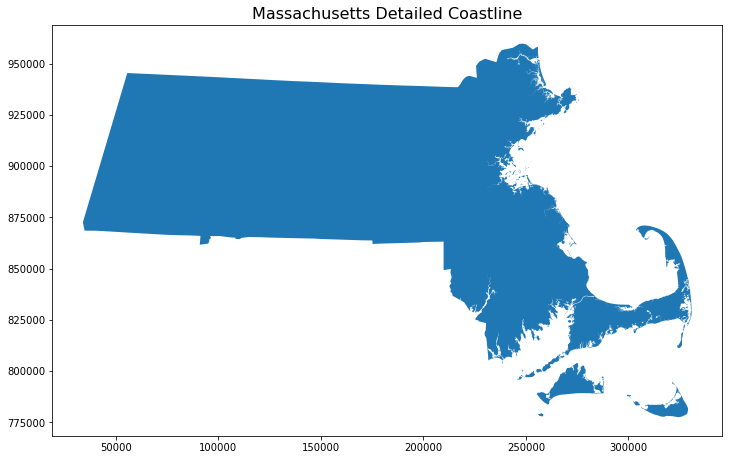

In [3]:
# View CRS and plot.
print(outline_25k.crs)
outline_25k.plot(figsize=(12,12))
plt.title('Massachusetts Detailed Coastline', fontsize=16)
plt.show()

### Massachusetts ZCTAs

In [4]:
# Import Zip Code Tabulation Areas within Massachusetts.
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 47.1+ KB


epsg:4269


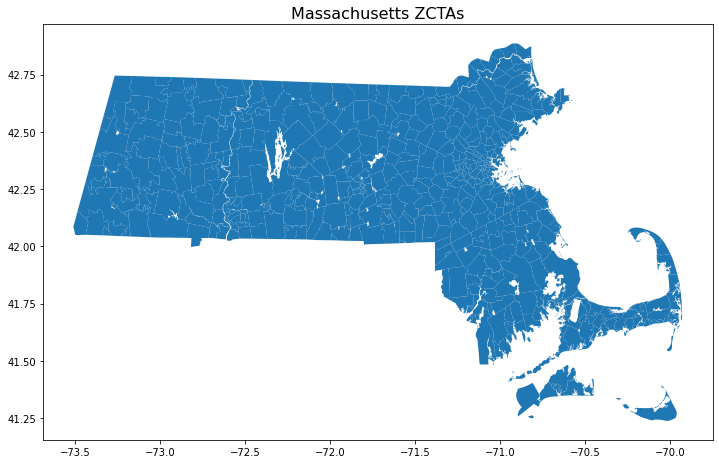

In [5]:
# View CRS and plot.
print(ma_zcta.crs)
ma_zcta.plot(figsize=(12,12))
plt.title('Massachusetts ZCTAs', fontsize=16)
plt.show()

In [6]:
# Convert CRS to Massachusetts Mainland EPSG 6491.
outline_25k = outline_25k.to_crs('epsg:6491')
ma_zcta = ma_zcta.to_crs('epsg:6491')
# Confirm CRSs match.
outline_25k.crs == ma_zcta.crs

True

In [7]:
# Clip ZCTA GDF to 25k MA outline.
ma_zcta_25k = gpd.clip(ma_zcta, outline_25k)
ma_zcta_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 50.9+ KB


### Boston Region Metropolitan Planning Organization (MPO)

In [8]:
# Import boundaries from Boston Region Metropolitan Planning Organization.
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    13 non-null     int64   
 1   MPO         13 non-null     object  
 2   created_us  0 non-null      object  
 3   created_da  13 non-null     object  
 4   last_edite  2 non-null      object  
 5   last_edi_1  13 non-null     object  
 6   GlobalID    13 non-null     object  
 7   ShapeSTAre  13 non-null     float64 
 8   ShapeSTLen  13 non-null     float64 
 9   geometry    13 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.1+ KB


In [9]:
# View MPO dataset.
mpo

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


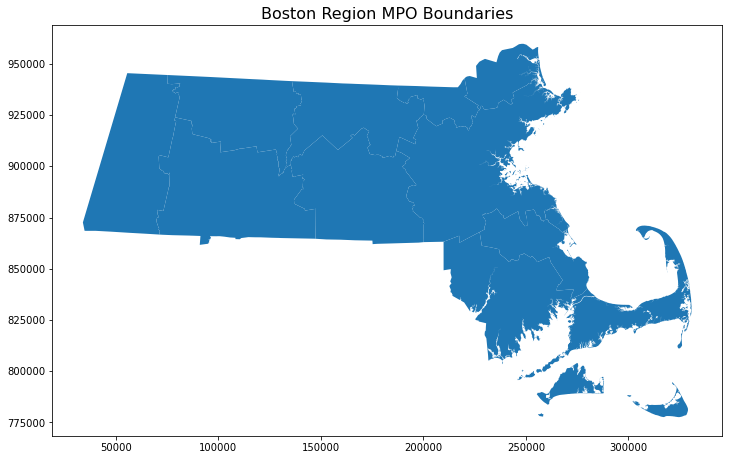

In [10]:
# Convert MPO CRS to EPSG 6491 and plot.
mpo = mpo.to_crs('epsg:6491')
mpo.plot(figsize=(12,12))
plt.title('Boston Region MPO Boundaries', fontsize=16)
plt.show()

In [11]:
# Extract only Boston Region from MPO.
boston_region = mpo.loc[mpo.MPO == 'Boston Region'].reset_index()
boston_region

,index,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,10,12,Boston Region,None,1970-01-01,DINOCCOD,2018-04-18,{3801574E-3CF1-4344-BE7C-8B2FBA431DD8},3.524379e+09,1.665026e+06,"MULTIPOLYGON (((261954.246 925125.468, 261961...."


In [12]:
# Extract ZCTAs within the Boston Region using the centroid of the ZCTAs.
boston_zcta = ma_zcta_25k[ma_zcta_25k.centroid.within(boston_region.geometry[0])].reset_index()
boston_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       159 non-null    int64   
 1   STATEFP00   159 non-null    object  
 2   ZCTA5CE00   159 non-null    object  
 3   GEOID00     159 non-null    object  
 4   CLASSFP00   159 non-null    object  
 5   MTFCC00     159 non-null    object  
 6   FUNCSTAT00  159 non-null    object  
 7   ALAND00     159 non-null    int64   
 8   AWATER00    159 non-null    int64   
 9   INTPTLAT00  159 non-null    object  
 10  INTPTLON00  159 non-null    object  
 11  PARTFLG00   159 non-null    object  
 12  geometry    159 non-null    geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 16.3+ KB


In [13]:
# View the Boston Region ZCTAs.
boston_zcta

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
1,32,25,01867,2501867,B5,G6350,S,25857991,46300,+42.5351829,-071.1054234,N,"POLYGON ((234193.323 919471.462, 234167.381 91..."
2,33,25,01880,2501880,B5,G6350,S,18969895,1554312,+42.5043600,-071.0640609,N,"POLYGON ((233593.527 918646.107, 233786.679 91..."
3,34,25,01730,2501730,B5,G6350,S,34703585,424511,+42.4993313,-071.2819054,N,"POLYGON ((215991.167 913794.709, 215916.137 91..."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,489,25,02030,2502030,B5,G6350,S,39440450,832120,+42.2341291,-071.2834628,N,"POLYGON ((215268.989 884982.344, 215020.550 88..."
155,490,25,02052,2502052,B5,G6350,S,37335006,608718,+42.1845991,-071.3053065,N,"POLYGON ((214616.455 880362.751, 214622.559 88..."
156,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90..."
157,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89..."


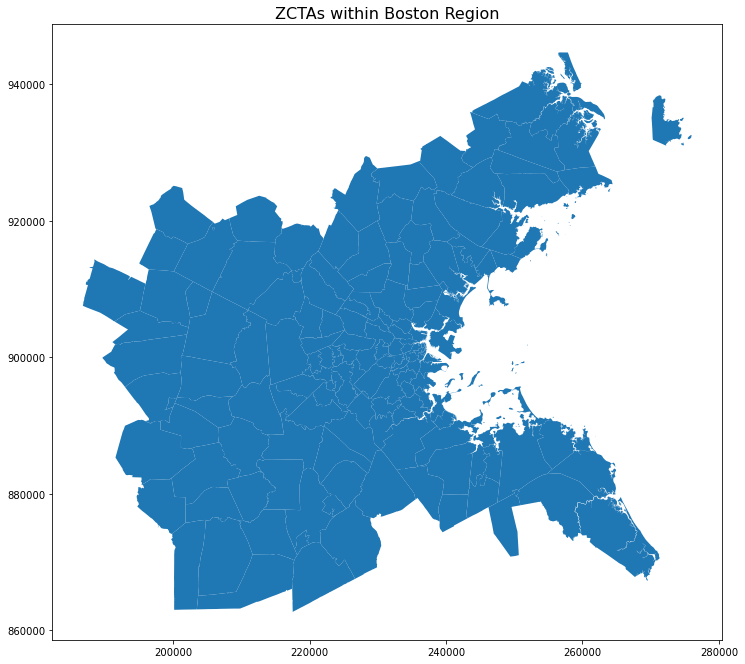

In [14]:
# Plot the Boston Region ZCTAs.
boston_zcta.plot(figsize=(12,12))
plt.title('ZCTAs within Boston Region', fontsize=16)
plt.show()

### Define Functions `convert_n_clip` and `read_n_clip`
`convert_n_clip` takes two GeoDataFrames (GDF): one to process (gdf) and one whose extent will be used to clip. The function converts the coordinate reference system (CRS) of the original GDF and clips it to the extent of the extent GDF.

In [15]:
def convert_n_clip(orig_gdf, extent_gdf):
    """
    Takes two GeoDataFrames (GDF): one to process (orig_gdf) and one whose extent will be used to clip (extent_gdf).
    Converts the coordinate reference system (CRS) of the orig_gdf to the CRS of extent_gdf.
    Clips to the extent of orig_gdf to the extent of extent_gdf.
    Returns clipped GDF.
    
    Inputs:
    orig_gdf = GDF to process
    extent_gdf = GDF whose extent to use
    
    Example:
    ma_schools = convert_n_clip(usa_schools, ma_boundary)
    """
    orig_gdf = orig_gdf.to_crs(extent_gdf.crs)
    clipped_gdf = gpd.clip(orig_gdf, extent_gdf)
    return clipped_gdf   

`read_n_clip` takes a filepath for a shapefile and a GDF whose extent will be used to clip the shapefile. The function reads in the shapefile and uses `convert_n_clip` to convert the coordinate reference system (CRS) of the original GDF and clip it to the extent of the extent GDF.

In [16]:
def read_n_clip(filepath, extent_gdf):
    """
    Takes a filepath for a shapefile and a GeoDataFrame (GDF).
    Reads in the file.
    Uses convert_n_clip function to convert to the coordinate reference system (CRS)
    of the GDF and clip to the extent of the GDF. 
    Returns clipped GDF.
    
    Inputs:
    filepath = relative filepath for shapefile to read
    extent_gdf = GDF whose extent to use
    
    Example:
    ma_water = read_n_clip('./data/usa/water.shp', ma_boundary)
    """
    shapefile = gpd.read_file(filepath)
    clipped_shapefile = convert_n_clip(shapefile, extent_gdf)
    return clipped_shapefile

In [17]:
# read_n_clip Boston surface water.
boston_water = read_n_clip('./data/hydro25k/HYDRO25K_POLY.shp', boston_zcta)
print(boston_water.crs)
boston_water.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12720 entries, 7279 to 71450
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MINOR_TOT   12720 non-null  object  
 1   POLY_CODE   12720 non-null  int64   
 2   PWSID       87 non-null     object  
 3   PALIS_ID    12720 non-null  int64   
 4   SOURCE      12720 non-null  object  
 5   MINOR_NUM   12720 non-null  float64 
 6   RESOLUTION  12720 non-null  object  
 7   NAME        785 non-null    object  
 8   JOIN_ID     12720 non-null  int64   
 9   COASTAL     12720 non-null  int64   
 10  SHAPE_AREA  12720 non-null  float64 
 11  SHAPE_LEN   12720 non-null  float64 
 12  geometry    12720 non-null  geometry
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 1.4+ MB


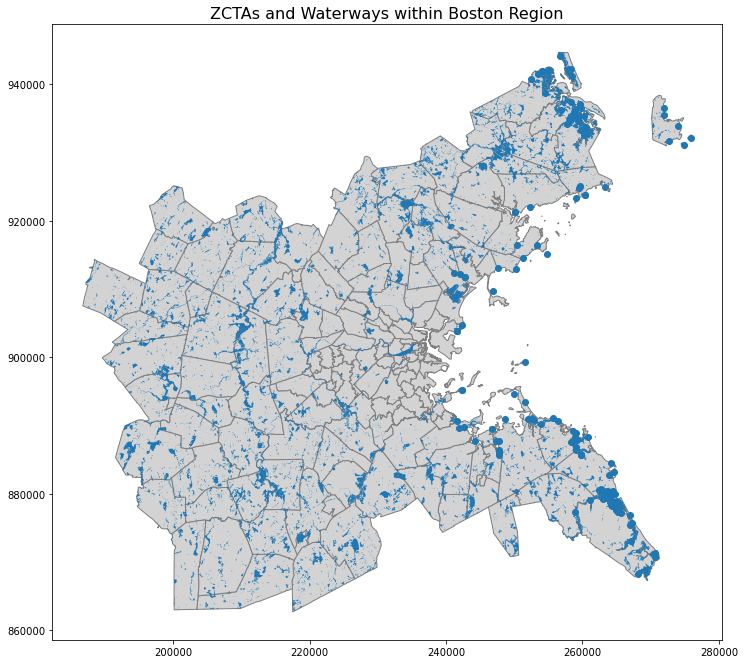

In [18]:
# Plot the Boston Region ZCTAs with surface water.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
plt.title('ZCTAs and Waterways within Boston Region', fontsize=16)
plt.show()

## Find Tufts University and Boston University Locations
To find the locations of Tufts University and Boston University (BU), the Massachusetts Colleges and Universities shapefile was processed with `read_n_clip` to read the shapefile and clip it to the extent of `boston_zcta`. Tufts and BU were then extracted into a GeoDataGrame.

In [19]:
# read_n_clip Boston MPO colleges.
colleges = read_n_clip('./data/colleges/COLLEGES_PT.shp', boston_zcta)
print(colleges.crs)
colleges.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 135 entries, 21 to 244
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COLLEGE     135 non-null    object  
 1   CAMPUS      52 non-null     object  
 2   ADDRESS     135 non-null    object  
 3   CITY        135 non-null    object  
 4   ZIPCODE     135 non-null    object  
 5   PLUS_FOUR   22 non-null     object  
 6   GEOG_TOWN   135 non-null    object  
 7   MAIN_TEL    135 non-null    object  
 8   URL         135 non-null    object  
 9   NCES_ID     120 non-null    object  
 10  TYPE        135 non-null    object  
 11  NCES_TYPE   135 non-null    object  
 12  CATEGORY    135 non-null    object  
 13  DEGREEOFFR  135 non-null    object  
 14  AWARDSOFFR  135 non-null    object  
 15  LARGEPROG   79 non-null     object  
 16  CAMPUSSETT  135 non-null    object  
 17  CAMPUSHOUS  135 non-null    object  
 18  L_SRC       135 non-null    obj

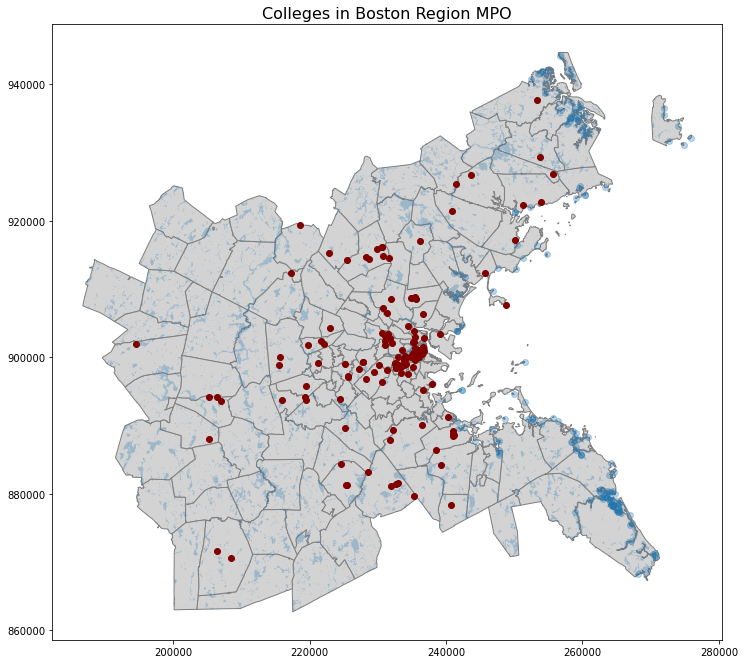

In [20]:
# Plot Boston MPO colleges.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
colleges.plot(ax=ax, color='maroon')
plt.title('Colleges in Boston Region MPO', fontsize=16)
plt.show()

In [21]:
# List all college names.
college_list = list(colleges.COLLEGE.unique())
college_list

['Dean College',
 "Mafy's Nails Academy",
 'Tri County Regional Vocational Technical High School Adult Education',
 'Toni & Guy Hairdressing Academy',
 'Universal Technical Institute of Massachusetts Inc',
 'University of Phoenix-Boston',
 'Curry College',
 'Massachusetts Bay Community College',
 'Mansfield Beauty Schools',
 'Massachusetts School of Barbering',
 'Newbury College',
 'Boston Career Institute',
 'Boston College',
 'Harvard University',
 'Boston University School of Medicine',
 'Massachusetts College of Pharmacy and Health Science',
 'Massachusetts College of Art and Design',
 'Wentworth Institute of Technology',
 'School of the Museum of Fine Arts',
 'Boston Graduate School of Psychoanalysis Inc',
 'Blessed John Xxiii National Seminary',
 'Simmons College',
 'Northeastern University Professional Advancement Network',
 'Northeastern University',
 'New England Conservatory of Music',
 'Emmanuel College',
 'Ali May Academy',
 'Quincy College',
 'Boston Baptist College',
 'La

In [22]:
# Select only names matching Tufts University or Boston University.
colleges_select = colleges.loc[colleges.COLLEGE.isin(['Tufts University', 'Boston University'])]
colleges_select

,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,NCES_ID,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,164988,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)
164,Tufts University,Boston Campus,145 Harrison Avenue,Boston,02111,None,BOSTON,(617) 636-7000,http://medicine.tufts.edu/,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (236057.132 900054.525)


In [23]:
# Select only the Medford/Somerville Tufts Campus and the main BU Campus.
tufts_bu = colleges_select.iloc[[0, 1]]
tufts_bu

,COLLEGE,CAMPUS,ADDRESS,CITY,ZIPCODE,PLUS_FOUR,GEOG_TOWN,MAIN_TEL,URL,NCES_ID,TYPE,NCES_TYPE,CATEGORY,DEGREEOFFR,AWARDSOFFR,LARGEPROG,CAMPUSSETT,CAMPUSHOUS,L_SRC,geometry
136,Tufts University,Medford/Somerville Campus,419 Boston Avenue,Medford,02155,None,MEDFORD,(617) 628-5000,http://www.tufts.edu,168148,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Two but less than 4 years certificate;Bachelor...,None,Suburb: Large,Yes,nces.ed.gov,POINT (231416.402 906514.073)
163,Boston University,Charles River Campus,1 Silber Way,Boston,02215,None,BOSTON,(617) 353-2000,http://www.bu.edu,164988,PRI,"4-year, Private not-for-profit",Research University,"C, B, PBC, M, PMC, D",Less than one year certificate;One but less th...,None,City: Large,Yes,nces.ed.gov,POINT (232983.739 899977.282)


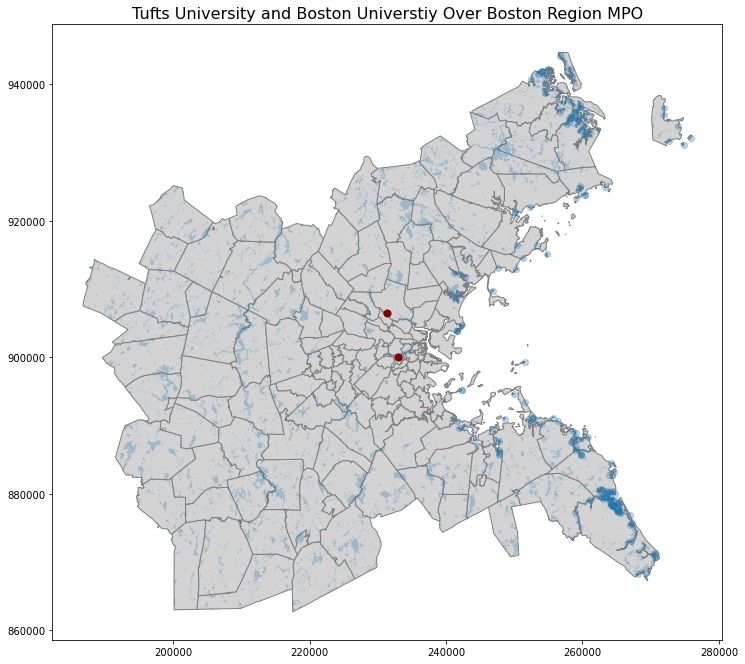

In [24]:
# Plot Tufts and BU.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Tufts University and Boston Universtiy Over Boston Region MPO', fontsize=16)
plt.show()

## Import Mass Transit Stops and Routes

### MBTA Bus Stops

In [25]:
# read_n_clip MBTA bus stops and view info.
bos_bus = read_n_clip('./data/MBTA_Bus_Routes_and_Stops/MBTA_Bus_Routes_and_Stops.shp', boston_zcta)
print(bos_bus.crs)
bos_bus.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7710 entries, 0 to 7809
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   7710 non-null   int64   
 1   STOP_ID    7710 non-null   int64   
 2   STOP_NAME  7710 non-null   object  
 3   TOWN       7710 non-null   object  
 4   TOWN_ID    7710 non-null   int64   
 5   geometry   7710 non-null   geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 421.6+ KB


### MBTA Rapid Transit (T) Stops and Routes

In [26]:
# read_n_clip MBTA rapid transit (T) stops and view info.
bos_rt_node = read_n_clip('./data/mbta_rapid_transit/MBTA_NODE.shp', boston_zcta)
print(bos_rt_node.crs)
bos_rt_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   166 non-null    object  
 1   LINE      166 non-null    object  
 2   TERMINUS  166 non-null    object  
 3   ROUTE     166 non-null    object  
 4   geometry  166 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 7.8+ KB


In [27]:
# read_n_clip MBTA rapid transit (T) routes and view info.
bos_rt_route = read_n_clip('./data/mbta_rapid_transit/MBTA_ARC.shp', boston_zcta)
print(bos_rt_route.crs)
bos_rt_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       138 non-null    object  
 1   ROUTE      138 non-null    object  
 2   GRADE      138 non-null    int64   
 3   SHAPE_LEN  138 non-null    float64 
 4   geometry   138 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 6.5+ KB


### Commuter Rail Stops and Routes

In [28]:
# read_n_clip Commuter Rail stops and view info.
bos_train_node = read_n_clip('./data/trains/TRAINS_NODE.shp', boston_zcta)
print(bos_train_node.crs)
bos_train_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 201 entries, 8 to 386
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION     201 non-null    object  
 1   C_RAILSTAT  192 non-null    object  
 2   AMTRAK      29 non-null     object  
 3   MAP_STA     109 non-null    object  
 4   LINE_BRNCH  198 non-null    object  
 5   STATE       201 non-null    object  
 6   geometry    201 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 12.6+ KB


In [29]:
# read_n_clip Commuter Rail routes and view info.
bos_train_route = read_n_clip('./data/trains/TRAINS_RTE_TRAIN.shp', boston_zcta)
print(bos_train_route.crs)
bos_train_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13 entries, 5 to 18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   COMM_LINE  13 non-null     object  
 1   COMMRAIL   13 non-null     object  
 2   SHAPE_LEN  13 non-null     float64 
 3   geometry   13 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 520.0+ bytes


### Map Mass Transit with Base Map

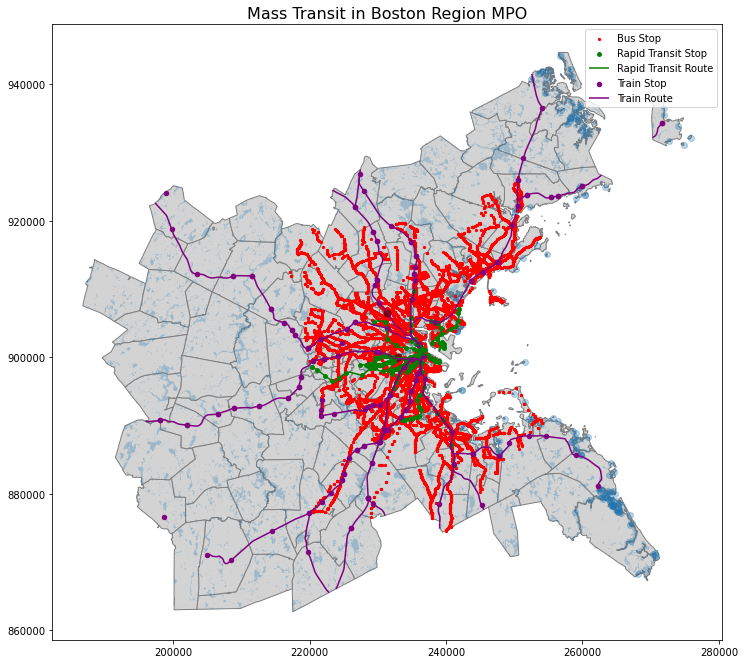

In [30]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=5, label='Bus Stop')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Mass Transit in Boston Region MPO', fontsize=16)
plt.legend()
plt.show()

## Limit Study Area to Extent of Rapid Transit
Judging by the vast extent of mass transit and the locations of Tufts and BU, the outer ZCTAs within the Boston Region MPO are untenable for regular commutes to campus. The T is more commonly (and reasonably) used for commuting. To limit the study area to the extent of the T for a more realistic comparison of ZCTAs, the following steps were used:
1. Extract the rectangular bounds of MBTA Rapid Transit (T) stops.
1. Create a bounding box with `shapely.geometry.box`.
1. Add a buffer to the bounding box and store as a new extent.
1. Extract Boston Region ZCTAs whose centroids are within the extent.

In [31]:
# Extract bounds of Boston Rapid Transit (T) nodes.
rt_bounds = bos_rt_node.geometry.total_bounds
rt_bounds

array([220391.71303283, 884240.96758161, 241840.82146882, 909753.44856537])

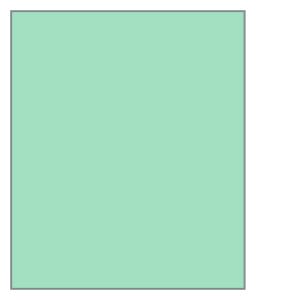

In [32]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box = box(rt_bounds[0], rt_bounds[1], rt_bounds[2], rt_bounds[3])
rt_bound_box

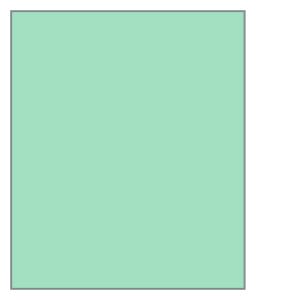

In [33]:
# Store the extent as a Shapely Polygon in a variable called graph_extent.
graph_extent = rt_bound_box.buffer(0.1, join_style=2)
graph_extent

In [34]:
# Extract Boston Region ZCTAs within the graph extent using the centroid of the ZCTAs.
rt_zcta = boston_zcta[boston_zcta.centroid.within(graph_extent)]
rt_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       69 non-null     int64   
 1   STATEFP00   69 non-null     object  
 2   ZCTA5CE00   69 non-null     object  
 3   GEOID00     69 non-null     object  
 4   CLASSFP00   69 non-null     object  
 5   MTFCC00     69 non-null     object  
 6   FUNCSTAT00  69 non-null     object  
 7   ALAND00     69 non-null     int64   
 8   AWATER00    69 non-null     int64   
 9   INTPTLAT00  69 non-null     object  
 10  INTPTLON00  69 non-null     object  
 11  PARTFLG00   69 non-null     object  
 12  geometry    69 non-null     geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 7.5+ KB


In [35]:
# View first five rows of rt_zcta.
rt_zcta.head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482...."
4,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90..."
5,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073...."
6,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90..."
7,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89..."


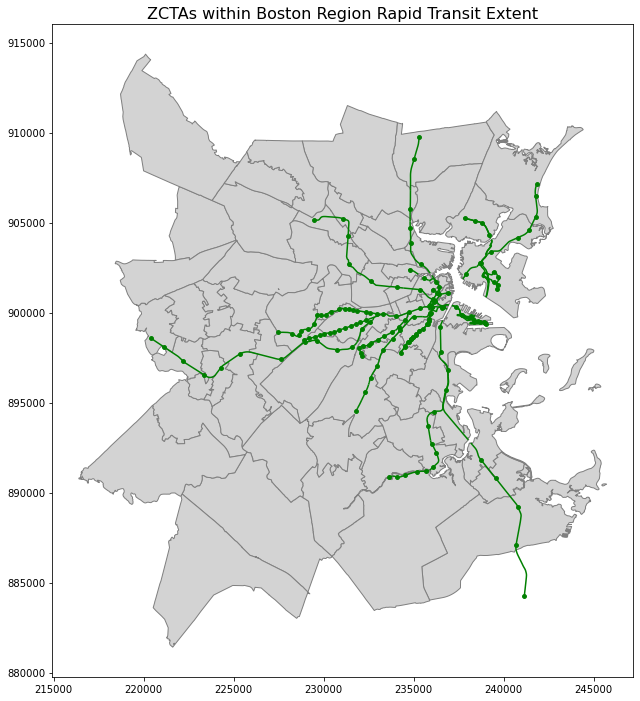

In [36]:
# Plot the Boston Region ZCTAs within graph extent to confirm success.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
plt.title('ZCTAs within Boston Region Rapid Transit Extent', fontsize=16)
plt.show()

### Clip All Relevant GDFs
The following GDFs were clipped to the new `rt_zcta` extent:
- `boston_water`
- `bos_bus`
- `bos_train_node`
- `bos_train_route`

Because `bos_rt_node` was used to create the extent and `bos_rt_route` connects all T stops, `bos_rt_route` does not need to be clipped.

In [37]:
# Clip all relevant GDFs.
boston_water = gpd.clip(boston_water, rt_zcta)
bos_bus = gpd.clip(bos_bus, rt_zcta)
bos_train_route = gpd.clip(bos_train_route, rt_zcta)
bos_train_node = gpd.clip(bos_train_node, rt_zcta)

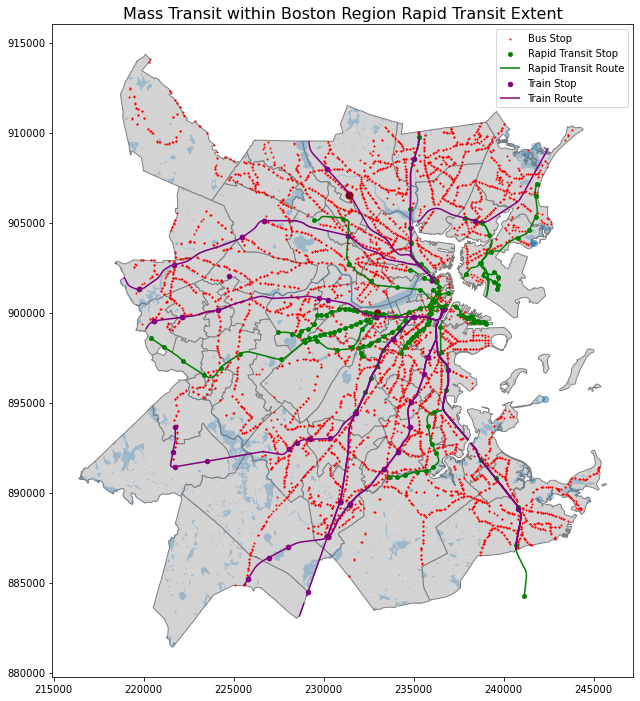

In [38]:
# Plot new extent with mass transit and schools.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=1, label='Bus Stop')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Mass Transit within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

#### TEST CODE

bos_bus.head()

bos_bus_latlong = bos_bus.to_crs('epsg:4326')
bos_bus_latlong

bos_bus['latitude'] = bos_bus_latlong.geometry.y
bos_bus['longitude'] = bos_bus_latlong.geometry.x
bos_bus.head()

m_1 = folium.Map(location=[42.32, -71.0589], tiles='openstreetmap', zoom_start=20)
mc_1 = MarkerCluster()
for idx, row in bos_bus.iterrows():
    mc_1.add_child(folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='red', icon='bus')))

mc_1.add_to(m_1)
m_1

## Analyze Mass Transit Stops
As Tufts University and Boston University are fairly far walking distance from one another, it is crucial that the home's location be easily accessible by mass transit. Transit stops were selected as an indicator for convenience of mass transit. While the routes are also important to consider, the stops are the on-off points to transit lines and necessary to accessing the transit systems.

The density of mass transit stops was calculated with the following steps:
1. Function `count_records` was created to count the number of records in a GDF within polygons of another GDF.
1. `count_records` was used on the GDFs for bus stops, T stops, and train stops in the limited `rt_zcta` extent.
1. Function `multimerge` was created to merge multiple DataFrames on the same column or list of columns. 
1. `multimerge` was used to add all mass transit stop counts to `rt_zcta` 
1. Total stops and stop density were calculated for all ZCTAs and mapped.

### Count Public Transit Nodes per ZCTA

#### Define Function `count_records`
`count_records` takes a GeoDataFrame of records to count and a GDF of polygons to count how many records are within each polygon. It outputs a DataFrame with the specified polygon column and counts. The optional argument `op` for `gpd.sjoin` defaults to `'within'` unless otherwise specified.

In [39]:
def count_records(records_gdf, polygon_gdf, polygon_col, count_col, op='within'):
    """
    Takes a GeoDataFrame of records to count and a GDF of polygons to count how 
    many records are within each polygon. 
    Outputs a DataFrame with the specified polygon column and counts.
    Optional argument op defaults to 'within' unless otherwise specified.
    
    Inputs:
    records_gdf = GDF of records to count
    polygon_gdf = GDF of polygons to count from
    polygon_col = name of column in polygon_gdf
        e.g. 'name'
    count_col = name of column for counts in output
        e.g. 'tree_count'
    op = op argument for sjoin; defaults to 'within' unless otherwise specified
    
    Example:
    tree_count = count_records(trees, towns, 'name', 'tree_count')
    """
    spatial_join = gpd.sjoin(records_gdf, polygon_gdf, how='left', op=op)
    records_count = spatial_join[polygon_col].value_counts().reset_index()
    records_count.columns = [polygon_col, count_col]
    return records_count

#### Count MBTA Bus Stops per ZCTA

In [40]:
# count_records for bos_bus within rt_zcta.
zcta_bus_count = count_records(bos_bus, rt_zcta, 'ZCTA5CE00', 'bus_stop_count')
zcta_bus_count.describe()

,bus_stop_count
count,67.000000
mean,76.686567
std,65.239468
min,1.000000
25%,27.500000
50%,74.000000
75%,105.500000
max,334.000000


#### Count MBTA T Stops per ZCTA

In [41]:
# count_records for bos_rt_node within rt_zcta.
zcta_rt_count = count_records(bos_rt_node, rt_zcta, 'ZCTA5CE00', 'rt_stop_count')
zcta_rt_count.describe()

,rt_stop_count
count,43.000000
mean,3.837209
std,3.696396
min,1.000000
25%,1.000000
50%,2.000000
75%,5.500000
max,15.000000


#### Count Commuter Rail Stops per ZCTA

In [42]:
# count_records for bos_train_node within rt_zcta.
zcta_train_count = count_records(bos_train_node, rt_zcta, 'ZCTA5CE00', 'train_stop_count')
zcta_train_count.describe()

,train_stop_count
count,31.00000
mean,3.00000
std,2.46306
min,1.00000
25%,2.00000
50%,2.00000
75%,3.50000
max,10.00000


### Define Function `multimerge`
`multimerge` takes a base DataFrame (DF) and merges it with each DF in a list of DataFrames on the specified column or list of columns and with the specified 'how'. The function assumes the specified column(s) exist(s) across all DFs.

In [43]:
def multimerge(left_df, df_list, on_col, how):
    """
    Takes a base DataFrame and merges with a list of DataFrames on the 
    specified column or list of columns and with the specified 'how'.
    Assumes on_col exists across all DFs.
    
    Inputs:
    left_df = base DF
    df_list = list of DFS
        e.g. [df1, df2, df3]
    on_col = bracketed column name or list of columns (same across DFs)
        e.g. ['name'], ['name', 'address']
    how = how argument
        e.g. 'left'
    
    Example:
    town_schools = multimerge(town, [elem, middle, high], ['town_name'], 'left')
    """
    merge_df = left_df.copy()
    for i in range(len(df_list)):
        merge_df = merge_df.merge(df_list[i], on=on_col, how=how)
    return merge_df

### Calculate Mass Transit Density per ZCTA

In [44]:
# Merge rt_zcta with all transit stop counts
count_list = [zcta_bus_count, zcta_rt_count, zcta_train_count]
zcta_nodes = multimerge(rt_zcta, count_list, ['ZCTA5CE00'], 'left').fillna(0)
zcta_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             69 non-null     int64   
 1   STATEFP00         69 non-null     object  
 2   ZCTA5CE00         69 non-null     object  
 3   GEOID00           69 non-null     object  
 4   CLASSFP00         69 non-null     object  
 5   MTFCC00           69 non-null     object  
 6   FUNCSTAT00        69 non-null     object  
 7   ALAND00           69 non-null     int64   
 8   AWATER00          69 non-null     int64   
 9   INTPTLAT00        69 non-null     object  
 10  INTPTLON00        69 non-null     object  
 11  PARTFLG00         69 non-null     object  
 12  geometry          69 non-null     geometry
 13  bus_stop_count    69 non-null     float64 
 14  rt_stop_count     69 non-null     float64 
 15  train_stop_count  69 non-null     float64 
dtypes: float64(3), geome

In [45]:
# View first five rows of new GDF.
zcta_nodes.head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482....",53.0,0.0,2.0
1,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90...",23.0,1.0,0.0
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",108.0,0.0,0.0
3,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90...",99.0,0.0,1.0
4,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89...",22.0,0.0,0.0


In [46]:
# Calculate total transit stops in each ZCTA.
zcta_nodes['nodes_count'] = zcta_nodes.bus_stop_count + zcta_nodes.rt_stop_count + zcta_nodes.train_stop_count
zcta_nodes

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count,nodes_count
0,31,25,02458,2502458,B5,G6350,S,4709183,57045,+42.3541154,-071.1891300,N,"MULTIPOLYGON (((227500.026 901300.219, 227482....",53.0,0.0,2.0,55.0
1,35,25,02141,2502141,B5,G6350,S,1572423,44304,+42.3702998,-071.0825603,N,"POLYGON ((234064.636 902597.603, 234080.228 90...",23.0,1.0,0.0,24.0
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",108.0,0.0,0.0,108.0
3,37,25,02472,2502472,B5,G6350,S,10410330,355268,+42.3694508,-071.1779249,N,"POLYGON ((223853.273 902504.747, 223982.362 90...",99.0,0.0,1.0,100.0
4,39,25,02464,2502464,B5,G6350,S,1447706,29494,+42.3129751,-071.2188818,N,"POLYGON ((223497.366 896100.959, 223538.895 89...",22.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,482,25,02139,2502139,B5,G6350,S,3784723,368360,+42.3622881,-071.1037905,N,"POLYGON ((232130.866 902283.249, 232144.254 90...",81.0,1.0,0.0,82.0
65,484,25,02474,2502474,B5,G6350,S,7903556,518211,+42.4209494,-071.1563695,N,"POLYGON ((228762.296 906831.977, 228756.803 90...",79.0,0.0,0.0,79.0
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0,30.0
67,494,25,02130,2502130,B5,G6350,S,11393804,369565,+42.3072770,-071.1140555,N,"POLYGON ((231406.529 893484.217, 231413.864 89...",97.0,7.0,3.0,107.0


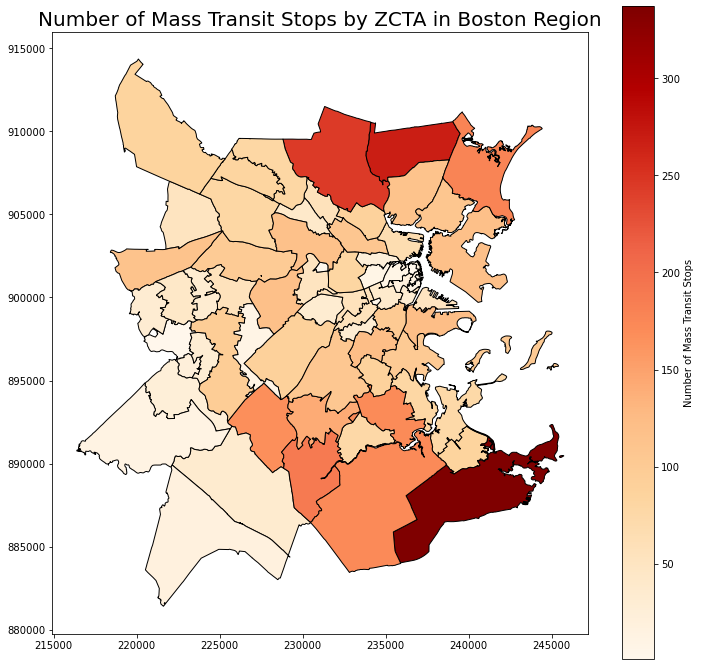

In [47]:
# Map the number of transit stops in each ZCTA.
ax = zcta_nodes.plot(column = 'nodes_count',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Number of Mass Transit Stops"})
plt.title('Number of Mass Transit Stops by ZCTA in Boston Region', fontsize = 20)
plt.show()

In [48]:
# Calculate node density in nodes/sqkm.
zcta_nodes['nodes_density'] = zcta_nodes.nodes_count/zcta_nodes.area*(10**6)
zcta_nodes.sort_values(by='nodes_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count,nodes_count,nodes_density
68,495,25,02222,2502222,B5,G6350,S,77896,0,+42.3664695,-071.0624939,N,"POLYGON ((235839.790 902134.685, 235852.488 90...",0.0,0.0,10.0,10.0,128.417764
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0,30.0,39.540383
55,378,25,02118,2502118,B5,G6350,S,2747439,0,+42.3378630,-071.0708157,N,"POLYGON ((235192.725 898164.265, 235174.169 89...",87.0,15.0,1.0,103.0,37.491925
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,-071.0538044,N,"MULTIPOLYGON (((236437.338 900792.044, 236429....",13.0,1.0,0.0,14.0,33.228131
32,249,25,02119,2502119,B5,G6350,S,4153196,0,+42.3238812,-071.0853318,N,"POLYGON ((235115.975 898168.657, 235148.036 89...",120.0,2.0,0.0,122.0,29.376895


In [49]:
# View statistics for nodes_density.
zcta_nodes.nodes_density.describe()

count     69.000000
mean      16.051534
std       16.371549
min        0.478677
25%        8.319632
50%       13.907207
75%       20.223958
max      128.417764
Name: nodes_density, dtype: float64

The top value for `nodes_density` greatly exceeds the next value, despite having a low `nodes_count`, indicating it is an outlier. The ZCTA in question, ZCTA 02222, appears to contain only TD Garden and North Station. The decision was made to set the `nodes_density` value for ZCTA 02222 to the median value to prevent skewing the analysis.

In [50]:
# ZCTA 02222 value for nodes_density set to median value.
zcta_nodes.loc[68, 'nodes_density'] = zcta_nodes.nodes_density.median()
zcta_nodes.sort_values(by='nodes_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,bus_stop_count,rt_stop_count,train_stop_count,nodes_count,nodes_density
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",13.0,8.0,9.0,30.0,39.540383
55,378,25,02118,2502118,B5,G6350,S,2747439,0,+42.3378630,-071.0708157,N,"POLYGON ((235192.725 898164.265, 235174.169 89...",87.0,15.0,1.0,103.0,37.491925
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,-071.0538044,N,"MULTIPOLYGON (((236437.338 900792.044, 236429....",13.0,1.0,0.0,14.0,33.228131
32,249,25,02119,2502119,B5,G6350,S,4153196,0,+42.3238812,-071.0853318,N,"POLYGON ((235115.975 898168.657, 235148.036 89...",120.0,2.0,0.0,122.0,29.376895
2,36,25,02143,2502143,B5,G6350,S,4007477,0,+42.3815721,-071.0969953,N,"MULTIPOLYGON (((234059.089 902586.579, 234073....",108.0,0.0,0.0,108.0,26.951361


In [51]:
# View statistics for nodes_density.
zcta_nodes.nodes_density.describe()

count    69.000000
mean     14.391961
std       8.923093
min       0.478677
25%       8.319632
50%      13.907207
75%      20.162023
max      39.540383
Name: nodes_density, dtype: float64

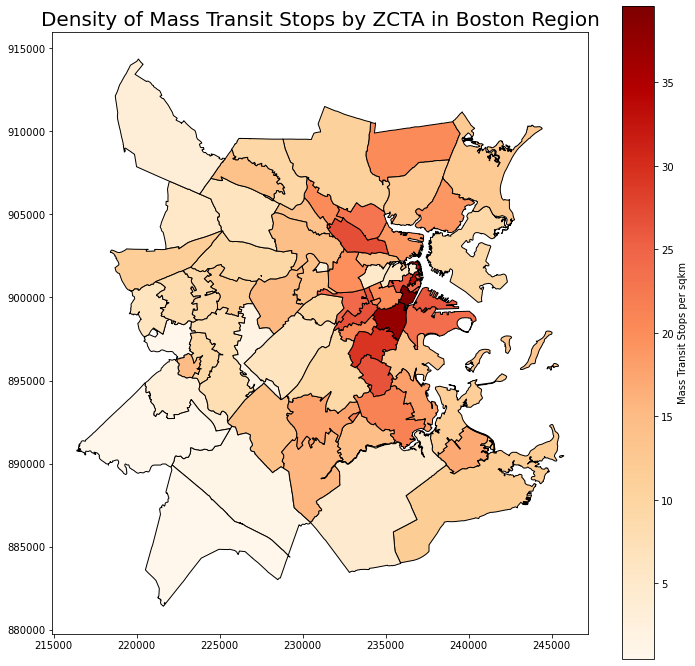

In [52]:
# Map the density of transit nodes in each ZCTA.
ax = zcta_nodes.plot(column = 'nodes_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Mass Transit Stops per sqkm"})
plt.title('Density of Mass Transit Stops by ZCTA in Boston Region', fontsize = 20)
plt.show()

## Locations and Density of Necessities
Accessibility of necessities and amenities is crucial to living anywhere. For the purposes of this study, necessities were defined as follows:
- Food
    - Groceries (e.g. supermarkets and food purveryors, like  greengrocers, butchers, etc.)
    - Prepared food (e.g. restaurants, cafes, etc.)
- Health Services
    - Community health centers
    - Hospitals
    - Healthcare facilities (e.g. doctors' offices, pharmacies, dentists, etc.)
- Public Services
    - Fire stations
    - Police stations
    - USPS Post Offices

Some data was imported from sources such as MassGIS while others were retrieved using `OpenStreetMap` and `OSMnx`'s `geometries_from_polygon` function.

### Create Extent in Latitude-Longitude to Use With `OSMnx`
To use `OSMnx geometries_from_polygon`, a polygon needs to be created in latitude-longitude coordinates. This was accomplished with the following steps:
1. Convert the T stops shapefile to `EPSG:4326` for lat-long and extract its rectangular bounds.
1. Create a bounding box with `shapely.geometry.box`.
1. Add a buffer to the bounding box and store as a new extent.

In [53]:
# Extract bounds of T Stops.
rt_bounds_latlong = bos_rt_node.to_crs('epsg:4326').geometry.total_bounds
rt_bounds_latlong

array([-71.25255434,  42.20753726, -70.99166451,  42.4375046 ])

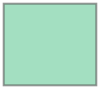

In [54]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box_latlong = box(rt_bounds_latlong[0], rt_bounds_latlong[1], rt_bounds_latlong[2], rt_bounds_latlong[3])
rt_bound_box_latlong

<class 'shapely.geometry.polygon.Polygon'>


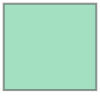

In [55]:
# Store the extent as a Shapely Polygon in a variable called graph_extent:
graph_extent_latlong = rt_bound_box_latlong.buffer(0.1, join_style=2)
print(type(graph_extent_latlong))
graph_extent_latlong

### Food Within Extent

#### Groceries

In [56]:
# Retrieve groceries features within graph_extent_latlong from OSMnx and view info.
grocery_tags = {'shop':['supermarket', 'greengrocer', 'bakery', 'butcher', 'deli', 'dairy', 'farm', 'seafood']}
grocery = ox.geometries_from_polygon(graph_extent_latlong, grocery_tags)
grocery = convert_n_clip(grocery, rt_zcta)
grocery.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 237 entries, 0 to 355
Columns: 114 entries, unique_id to type
dtypes: geometry(1), int64(1), object(112)
memory usage: 212.9+ KB


In [57]:
# View first five rows of groceries GDF.
grocery.head()

,unique_id,osmid,element_type,brand,brand:wikidata,brand:wikipedia,name,note,shop,geometry,...,name:zh-Hant,building:colour,building:min_level,roof:colour,UPDATE_DAT,operator:wikidata,operator:wikipedia,landuse,ways,type
0,node/314092543,314092543,node,Stop & Shop,Q3658429,en:Stop & Shop,Stop & Shop,store new since 2006 aerial imagery,supermarket,POINT (235831.905 897407.979),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/355795164,355795164,node,NaN,NaN,NaN,La Ronga Bakery & Delicatessen,NaN,bakery,POINT (232151.416 903802.162),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/431377975,431377975,node,NaN,NaN,NaN,Quebrada Baking Co.,NaN,bakery,POINT (229412.784 906211.019),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/460001186,460001186,node,NaN,NaN,NaN,Star Market,NaN,supermarket,POINT (231430.529 904430.448),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node/460211013,460211013,node,NaN,NaN,NaN,Star Market,NaN,supermarket,POINT (228901.367 902823.634),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
# Use count_records on groceries GDF.
zcta_grocery_count = count_records(grocery, rt_zcta, 'ZCTA5CE00', 'grocery_count')
zcta_grocery_count

,ZCTA5CE00,grocery_count
0,02138,13
1,02143,11
2,02130,9
3,02169,9
4,02472,8
...,...,...
57,02126,1
58,02459,1
59,02121,1
60,02129,1


#### Prepared food

In [97]:
# Retrieve prepared food features within graph_extent_latlong from OSMnx and view info.
prep_food_tags = {'amenity':['cafe', 'restaurant', 'fast_food']}
prep_food = ox.geometries_from_polygon(graph_extent_latlong, prep_food_tags)
prep_food = convert_n_clip(prep_food, rt_zcta)
prep_food.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2132 entries, 0 to 2992
Columns: 186 entries, unique_id to type
dtypes: geometry(1), int64(1), object(184)
memory usage: 3.0+ MB


In [98]:
# View first five rows of prepared food GDF.
prep_food.head()

,unique_id,osmid,element_type,amenity,cuisine,name,name:zh,geometry,addr:housenumber,opening_hours,...,roof:material,telephone,former:building,building_1,phone:alternate,highway,oneway,service,ways,type
0,node/325419354,325419354,node,restaurant,chinese,Dar Hee,達熙,POINT (237094.772 907512.932),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/326391966,326391966,node,restaurant,NaN,Tawakal Halal,NaN,POINT (238793.752 901798.067),389,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/329705548,329705548,node,fast_food,pizza,Big Daddy's,NaN,POINT (229587.646 901377.423),NaN,Mo-Su 11:00-22:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/345423108,345423108,node,restaurant,pizza,Romanza Pizzaria,NaN,POINT (233987.726 904915.453),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/345423146,345423146,node,fast_food,NaN,Dunkin' Donuts,NaN,POINT (232394.959 903738.778),519,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
# Use count_records on prepared food GDF.
zcta_prep_food_count = count_records(prep_food, rt_zcta, 'ZCTA5CE00', 'prep_food_count')
zcta_prep_food_count

,ZCTA5CE00,prep_food_count
0,02116,136
1,02139,112
2,02138,112
3,02128,108
4,02215,95
...,...,...
62,02458,3
63,02126,2
64,02460,2
65,02131,1


#### Define Function `calc_density`
The purpose of this function is to calculate the density of a set of records in a GeoDataFrame of polygons. It takes a base GeoDataFrame and, using function `multimerge`, merges it with a list of GeoDataFrames on the list of `on` columns and with the specified `how`. The GDFs within the list are expected to have columns with counts, and those columns are given in a list. The function then adds together the counts in specified columns and calculates the density.

In [62]:
def calc_density(orig_gdf, gdf_count_list, on_col, how, count_cols, total_count_col, density_col):
    """
    The purpose of this function is to calculate the density of a set of records
    in a GeoDataFrame of polygons.
    Takes a base GeoDataFrame and, using function multimerge, merges it with a list of GDFs 
    on the specified column or list of columns and with the specified 'how'.
    The GDFs within the list are expected to have columns with counts.
    Adds together the counts in specified columns, then calculates the density.
    Assumes on_col exists across all DFs.
    Assumes units of the GDF are in meters, with density output of per sqkm.
    
    Inputs:
    orig_gdf = base GDF
    gdf_count_list = list of GDFs with counts to calculate from
        e.g. [gdf1, gdf2, gdf3]
    on_col = bracketed column name or list of columns (same across GDFs)
        e.g. ['name'], ['name', 'address']
    how = how argument
        e.g. 'left'
    count_cols = bracketed list of column names with counts, order does not matter
        e.g. ['gdf1_count', 'gdf2_count', 'gdf3_count']
    total_count_col = string name for new column with total counts
        e.g. 'total_count'
    density_col = string name for new column with density (per sqkm)
        e.g. 'bike_density'
    
    Example:
    schools = [elem, middle, high]
    on_col = ['town_name', 'state']
    count_cols = ['elem_classrooms', 'middle_classrooms', 'high_classrooms']
    town_schools = multimerge(town, schools, on_col, 'left', count_cols, 'total_classrooms', 'classroom_density')
    """
    density_gdf = multimerge(orig_gdf, gdf_count_list, on_col, how).fillna(0)
    density_gdf[total_count_col] = 0.0
    for i in range(len(count_cols)):
        density_gdf[total_count_col] = density_gdf[total_count_col] + density_gdf[count_cols[i]]
    density_gdf[density_col] = density_gdf[total_count_col]/density_gdf.area*(10**6)
    return density_gdf

#### Calculate Food Density per ZCTA

In [100]:
# Use calc_density to calculate density of food establishments per ZCTA.
food_gdfs = [zcta_grocery_count, zcta_prep_food_count]
food_cols = ['grocery_count', 'prep_food_count']
zcta_food = calc_density(rt_zcta, food_gdfs, ['ZCTA5CE00'], 'left', food_cols, 'food_count', 'food_density')
# View five most food-dense ZCTAs.
zcta_food.sort_values(by='food_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,grocery_count,prep_food_count,food_count,food_density
62,437,25,02113,2502113,B5,G6350,S,272995,0,+42.3651696,-071.0553627,N,"POLYGON ((236403.940 901958.860, 236443.429 90...",4.0,43.0,47.0,172.176956
48,308,25,02199,2502199,B5,G6350,S,149678,0,+42.3474648,-071.0820577,N,"POLYGON ((234168.090 899801.270, 234292.861 89...",1.0,21.0,22.0,146.992162
68,495,25,02222,2502222,B5,G6350,S,77896,0,+42.3664695,-071.0624939,N,"POLYGON ((235839.790 902134.685, 235852.488 90...",2.0,7.0,9.0,115.575988
54,377,25,02110,2502110,B5,G6350,S,428520,0,+42.3573712,-071.0531804,N,"POLYGON ((236791.320 900796.888, 236751.472 90...",1.0,41.0,42.0,99.910762
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,-071.0538044,N,"MULTIPOLYGON (((236437.338 900792.044, 236429....",1.0,35.0,36.0,85.443766


In [101]:
# View stats for food_density
zcta_food.food_density.describe()

count     69.000000
mean      19.115156
std       35.553685
min        0.000000
25%        1.239379
50%        3.858959
75%       17.724871
max      172.176956
Name: food_density, dtype: float64

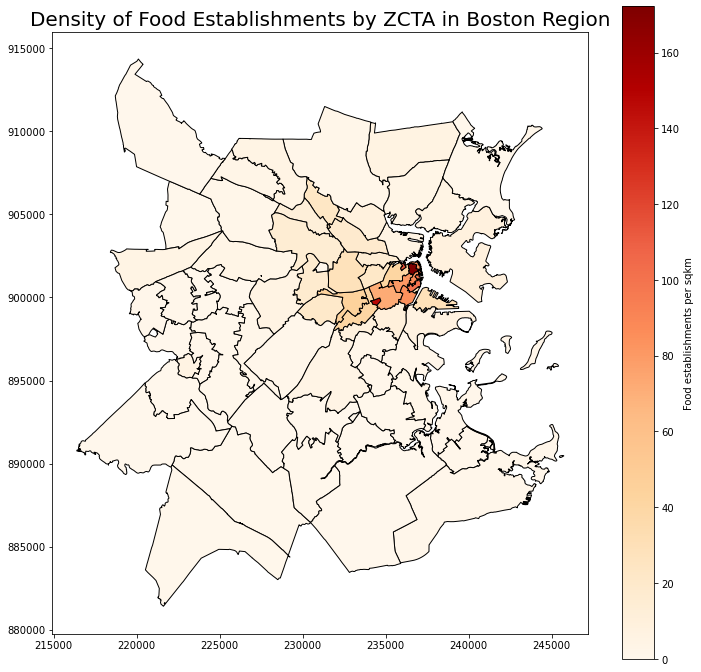

In [102]:
# Map the density of food establishments in each ZCTA.
ax = zcta_food.plot(column = 'food_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Food establishments per sqkm"})
plt.title('Density of Food Establishments by ZCTA in Boston Region', fontsize = 20)
plt.show()

### Health Services Within Extent

#### Community Health Centers

In [66]:
# read_n_clip Community Health Centers shapefile from MassGIS and view info.
comm_health = read_n_clip('./data/chcs/CHCS_PT.shp', rt_zcta)
comm_health.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 85 entries, 1 to 194
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SITE_NAME   85 non-null     object  
 1   SITE_TYPE   85 non-null     object  
 2   ADMIN_ONLY  85 non-null     object  
 3   ADDRESS     85 non-null     object  
 4   ADDRESS_OT  16 non-null     object  
 5   MAIL_CITY   85 non-null     object  
 6   ZIP         85 non-null     object  
 7   PO_BOX      0 non-null      object  
 8   TOWN        85 non-null     object  
 9   TOWN_ID     85 non-null     int64   
 10  SATELLITE   85 non-null     object  
 11  EYE         85 non-null     object  
 12  DENTAL      85 non-null     object  
 13  METHOD      85 non-null     object  
 14  GIS_ID      71 non-null     object  
 15  MCHC_CODE   85 non-null     object  
 16  MAD_ID      85 non-null     int64   
 17  geometry    85 non-null     geometry
dtypes: geometry(1), int64(2), object(15)
memory

In [67]:
# View first five rows of comm_health.
comm_health.head()

,SITE_NAME,SITE_TYPE,ADMIN_ONLY,ADDRESS,ADDRESS_OT,MAIL_CITY,ZIP,PO_BOX,TOWN,TOWN_ID,SATELLITE,EYE,DENTAL,METHOD,GIS_ID,MCHC_CODE,MAD_ID,geometry
1,Chinatown Clinic,NOS,N,885 Washington Street,None,Boston,02111,None,BOSTON,35,Y,N,N,G,S99,SCCHC,35145770,POINT (235848.295 899811.714)
3,St. Francis House Clinic,HOMELESS,N,39 Boylston Street,None,Boston,02116,None,BOSTON,35,Y,N,N,G,S101,BHCHP,35018316,POINT (235955.316 900313.222)
8,Teen Health Center at Cambridge Rindge and Lat...,SCHOOL,N,459 Broadway,None,Cambridge,02138,None,CAMBRIDGE,49,Y,N,N,G,S106,CHA,3624789,POINT (231966.092 902732.932)
9,The Great Hall,NOS,N,6 Norfolk Street,None,Dorchester,02124,None,BOSTON,35,Y,N,N,G,S107,CSHC,35103391,POINT (235304.694 893366.484)
11,Upham's Corner Adolescent Health & WIC,NOS,N,500 Columbia Road,None,Dorchester,02125,None,BOSTON,35,Y,N,N,G,S111,UCHC,35035283,POINT (235647.822 896122.920)


In [112]:
# Use count_records on comm_health.
zcta_comm_health_count = count_records(comm_health, rt_zcta, 'ZCTA5CE00', 'comm_health_count')
zcta_comm_health_count

,ZCTA5CE00,comm_health_count
0,02125,7
1,02139,7
2,02111,5
3,02151,5
4,02149,5
5,02118,4
6,02124,4
7,02143,3
8,02126,3
9,02171,3


#### Hospitals

In [114]:
# read_n_clip Hospitals shapefile from MassGIS and view info.
hospitals = read_n_clip('./data/acute_care_hospitals/HOSPITALS_PT.shp', rt_zcta)
hospitals.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 21 entries, 0 to 68
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   IDNUMBER    21 non-null     object  
 1   DPHID       21 non-null     int64   
 2   NAME        21 non-null     object  
 3   SHORTNAME   21 non-null     object  
 4   ADDRESS     21 non-null     object  
 5   TOWN        21 non-null     object  
 6   GEOG_TOWN   21 non-null     object  
 7   ZIPCODE     21 non-null     object  
 8   CHIAREGION  21 non-null     object  
 9   TELEPHONE   21 non-null     object  
 10  COHORT      21 non-null     object  
 11  HOSPSYSTEM  21 non-null     object  
 12  TAXSTATUS   21 non-null     object  
 13  BEDCOUNT    21 non-null     int64   
 14  ER_STATUS   21 non-null     object  
 15  TRAUMA_ADU  5 non-null      object  
 16  TRAUMA_PED  4 non-null      object  
 17  SPEPUBFUND  19 non-null     object  
 18  FYE         17 non-null     object  
 19  MA

In [70]:
# View first five rows of hospitals.
hospitals.head()

,IDNUMBER,DPHID,NAME,SHORTNAME,ADDRESS,TOWN,GEOG_TOWN,ZIPCODE,CHIAREGION,TELEPHONE,...,TAXSTATUS,BEDCOUNT,ER_STATUS,TRAUMA_ADU,TRAUMA_PED,SPEPUBFUND,FYE,MADID,EMSREGION,geometry
0,2069,2069,Beth Israel Deaconess Medical Center East,BIDMC East,330 Brookline Avenue,Boston,BOSTON,02215,Metro Boston,(617) 667-7000,...,Non-profit,248,N,None,None,Not Applicable,2017-09-30,35022096,4,POINT (232494.091 898890.122)
1,2085,2085,Steward St. Elizabeth's Medical Center,St. Elizabeth's Medical Center,736 Cambridge Street,Brighton,BOSTON,02135,Metro Boston,(617) 789-3000,...,For profit,252,Y,None,None,Not Applicable,2017-12-31,35156980,4,POINT (229003.958 899958.291)
2,2299,2299,Tufts Medical Center,Tufts Medical Center,800 Washington Street,Boston,BOSTON,02111,Metro Boston,(617) 636-5000,...,Non-profit,415,Y,Level 1,Level 1,Not Applicable,2017-09-30,35145764,4,POINT (235963.109 899998.149)
4,2167,2167,Massachusetts Eye and Ear Infirmary,Massachusetts Eye and Ear Infirmary,243 Charles Street,Boston,BOSTON,02114,Metro Boston,(617) 523-7900,...,Non-profit,41,Y,None,None,Not Applicable,2017-09-30,35163139,4,POINT (235396.614 901452.905)
5,2316,2316,Shriners Hospital For Children - Boston,Shriners Boston,51 Blossom Street,Boston,BOSTON,02114,Metro Boston,(617) 722-3000,...,Non-profit,30,N,None,None,Not Applicable,2017-12-31,35016066,4,POINT (235713.701 901489.419)


In [115]:
# Use count_records on hospitals.
zcta_hospitals_count = count_records(hospitals, rt_zcta, 'ZCTA5CE00', 'hospitals_count')
zcta_hospitals_count

,ZCTA5CE00,hospitals_count
0,02114,3
1,02115,3
2,02118,2
3,02215,2
4,02149,1
5,02139,1
6,02138,1
7,02130,1
8,02492,1
9,02186,1


#### Healthcare

In [72]:
# Retrieve healthcare features within graph_extent_latlong from OSMnx and view info.
health_tags = {'healthcare':True, 'amenity':['clinic', 'doctors', 'dentist', 'health_post', 'pharmacy']}
healthcare = ox.geometries_from_polygon(graph_extent_latlong, health_tags)
healthcare = convert_n_clip(healthcare, rt_zcta)
healthcare.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 322 entries, 0 to 500
Columns: 134 entries, unique_id to protected
dtypes: geometry(1), int64(1), object(132)
memory usage: 339.6+ KB


In [73]:
# View first five rows of healthcare GDF.
healthcare.head()

,unique_id,osmid,element_type,attribution,source,geometry,addr:city,addr:housenumber,addr:state,addr:street,...,massgis:OWNER_TYPE,massgis:POLY_ID,massgis:PRIM_PURP,massgis:PUB_ACCESS,massgis:SITE_NAME,massgis:SOURCE_MAP,massgis:TOWN_ID,owner,ownership,protected
0,node/61348061,61348061,node,Office of Geographic and Environmental Informa...,massgis_import_v0.1_20071008193615,POINT (228225.230 899815.766),Brighton,438,MA,Washington Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/257489648,257489648,node,NaN,NaN,POINT (235923.447 900015.140),Boston,755,NaN,Washington Street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/358278209,358278209,node,NaN,NaN,POINT (233490.267 891124.319),Mattapan,1575,NaN,Blue Hill Avenue,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/367777794,367777794,node,NaN,USGS Geonames,POINT (232386.086 898796.067),NaN,NaN,MA,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,node/391429098,391429098,node,NaN,NaN,POINT (228374.893 904620.489),NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
# Use count_records on healthcare.
zcta_healthcare_count = count_records(healthcare, rt_zcta, 'ZCTA5CE00', 'healthcare_count')
zcta_healthcare_count

,ZCTA5CE00,healthcare_count
0,02116,35
1,02130,19
2,02115,18
3,02135,13
4,02139,12
5,02138,12
6,02143,12
7,02215,11
8,02155,10
9,02114,9


#### Calculate Health Services Density per ZCTA

In [75]:
# Use calc_density to calculate density of health services per ZCTA.
health_gdfs = [zcta_comm_health_count, zcta_hospitals_count, zcta_healthcare_count]
health_cols = ['comm_health_count', 'hospitals_count', 'healthcare_count']
zcta_health = calc_density(rt_zcta, health_gdfs, ['ZCTA5CE00'], 'left', health_cols, 'health_count', 'health_density')
# View five most food-dense ZCTAs.
zcta_health.sort_values(by='health_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,comm_health_count,hospitals_count,healthcare_count,health_count,health_density
60,435,25,02116,2502116,B5,G6350,S,1712064,222385,+42.3499907,-071.0760802,N,"POLYGON ((234702.966 899809.334, 234675.900 89...",1.0,0.0,35.0,36.0,18.611098
62,437,25,02113,2502113,B5,G6350,S,272995,0,+42.3651696,-071.0553627,N,"POLYGON ((236403.940 901958.860, 236443.429 90...",2.0,0.0,2.0,4.0,14.653358
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",5.0,1.0,4.0,10.0,13.180128
20,115,25,02115,2502115,B5,G6350,S,1979415,162098,+42.3375449,-071.1061732,N,"POLYGON ((233785.591 900215.963, 233773.509 90...",0.0,3.0,18.0,21.0,9.806794
56,379,25,02114,2502114,B5,G6350,S,1065352,343761,+42.3631745,-071.0686463,N,"MULTIPOLYGON (((234691.735 900849.190, 234663....",1.0,3.0,9.0,13.0,9.662174


In [76]:
# View stats for health_density
zcta_health.health_density.describe()

count    69.000000
mean      2.144441
std       3.597263
min       0.000000
25%       0.207328
50%       0.700241
75%       2.080378
max      18.611098
Name: health_density, dtype: float64

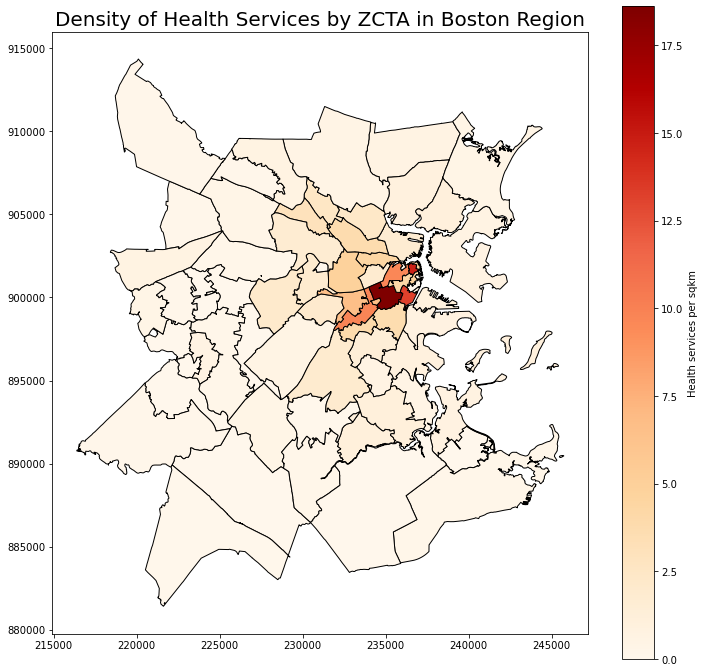

In [77]:
# Map the density of health services in each ZCTA.
ax = zcta_health.plot(column = 'health_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Health services per sqkm"})
plt.title('Density of Health Services by ZCTA in Boston Region', fontsize = 20)
plt.show()

### Public Services Within Extent

#### Fire Stations

In [78]:
# read_n_clip firestations shapefile from MassGIS and view info.
fire = read_n_clip('./data/firestations_pt/FIRESTATIONS_PT_MEMA.shp', rt_zcta)
fire.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 113 entries, 5 to 710
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      113 non-null    object  
 1   OFFICE    113 non-null    object  
 2   ADDRESS   113 non-null    object  
 3   CITY      113 non-null    object  
 4   STATE     113 non-null    object  
 5   ZIP       113 non-null    object  
 6   L_SRC     113 non-null    object  
 7   SOURCE    113 non-null    object  
 8   L_DATE    113 non-null    object  
 9   geometry  113 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 9.7+ KB


In [79]:
# View first five rows of fire GDF.
fire.head()

,NAME,OFFICE,ADDRESS,CITY,STATE,ZIP,L_SRC,SOURCE,L_DATE,geometry
5,MILTON FIRE DEPARTMENT,DEPT E 4,815 Blue Hill Ave.,MILTON,MA,01286,MAPC,MEMA,2006-08-16,POINT (232280.004 887730.431)
6,MILTON FIRE DEPARTMENT,Station 1- Headquarters,515 Canton Avenue,MILTON,MA,02186,MAPC,MEMA,2006-08-16,POINT (234642.734 889410.311)
7,MILTON FIRE DEPARTMENT,Station E 2,525 Adams Street,MILTON,MA,02186,MAPC,MEMA,2006-08-16,POINT (237885.224 889826.071)
38,REVERE FIRE DEPARTMENT,Engine 1,13 Walden Street,REVERE,MA,02151,MAPC,MEMA,2006-08-16,POINT (241572.264 906537.411)
39,REVERE FIRE DEPARTMENT,Engine 3,929 Winthrop Avenue,REVERE,MA,02151,MAPC,MEMA,2006-08-16,POINT (242387.724 904981.381)


In [117]:
# Use count_records on fire.
zcta_fire_count = count_records(fire, rt_zcta, 'ZCTA5CE00', 'fire_count')
zcta_fire_count

,ZCTA5CE00,fire_count
0,02155,6
1,02169,5
2,02151,5
3,02445,4
4,02143,3
5,02149,3
6,02459,3
7,02124,3
8,02453,3
9,02118,3


#### Police Stations

In [81]:
# read_n_clip police stations shapefile from MassGIS and view info.
police = read_n_clip('./data/policestations/POLICESTATIONS_PT_MEMA.shp', rt_zcta)
police.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 46 entries, 6 to 412
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      46 non-null     object  
 1   ADDRESS   46 non-null     object  
 2   CITY      46 non-null     object  
 3   STATE     46 non-null     object  
 4   ZIP       46 non-null     object  
 5   JURISDIC  46 non-null     object  
 6   L_SRC     45 non-null     object  
 7   SOURCE    46 non-null     object  
 8   L_DATE    46 non-null     object  
 9   geometry  46 non-null     geometry
dtypes: geometry(1), object(9)
memory usage: 4.0+ KB


In [82]:
# View first five rows of police GDF.
police.head()

,NAME,ADDRESS,CITY,STATE,ZIP,JURISDIC,L_SRC,SOURCE,L_DATE,geometry
6,"STATE POLICE STATION H-7, MILTON",685 HILLSIDE STREET,MILTON,MA,02186,STATE,MAPC,MEMA,2006-09-12,POINT (233598.434 885007.271)
42,BOSTON POLICE DEPARTMENT DISTRICT E-5,1708 CENTRE STREET,BOSTON,MA,02132,LOCAL,MEMA,CITY,2006-09-12,POINT (229001.867 892986.812)
43,BOSTON POLICE DEPARTMENT DISTRICTS A-1 AND A-15,40 NEW SUDBURY STREET,BOSTON,MA,02114,LOCAL,MEMA,CITY,2006-09-12,POINT (236217.474 901349.051)
44,BOSTON POLICE DEPARTMENT DISTRICT B-2,2400 WASHINGTON STREET,BOSTON,MA,02119,LOCAL,MEMA,CITY,2014-03-01,POINT (234279.794 897624.521)
45,BOSTON POLICE DEPARTMENT DISTRICT C-11,40 GIBSON STREET,BOSTON,MA,02122,LOCAL,MEMA,CITY,2006-09-12,POINT (236357.494 894265.901)


In [118]:
# Use count_records on police.
zcta_police_count = count_records(police, rt_zcta, 'ZCTA5CE00', 'police_count')
zcta_police_count

,ZCTA5CE00,police_count
0,02155,3
1,02118,3
2,02210,3
3,02465,2
4,02151,2
5,02135,2
6,02026,2
7,02128,2
8,02114,2
9,02186,2


#### USPS Post Offices

In [84]:
# Read in CSV files of USPS DDUs (Destination Delivery Units) obtained from USPS
usps_df = pd.read_csv('./data/USPS DDUs.csv')
# Convert to GeoDataFrame, setting CRS to WGS 84 Pseudo Mercator EPSG:3857
usps = gpd.GeoDataFrame(usps_df, geometry=gpd.points_from_xy(usps_df.x, usps_df.y))
usps = usps.set_crs('epsg:3857')

In [85]:
# View usps GDF.
usps

,AREA_ID,AREA_NAME,DISTRICT_ID,DISTRICT_NAME,LOCALE_KEY,LOCALE_NAME,FACILITY_TYPE,ADDRESS,CITY,STATE,...,DISTRICTID,STFIPS,STATE_ABBR,CDFIPS,NAME,LAST_NAME,PARTY,x,y,geometry
0,4B,NORTHEAST (B),20.0,GREATER BOSTON,V27697,BOYLSTON,POST_OFF,67 SHREWSBURY ST,BOYLSTON,MA,...,2502.0,25.0,MA,2.0,James P. McGovern,McGovern,Democrat,-7.985977e+06,5.211252e+06,POINT (-7985976.557 5211251.950)
1,4B,NORTHEAST (B),20.0,GREATER BOSTON,V21844,GREENDALE,POST_OFF,290 W BOYLSTON ST,WORCESTER,MA,...,2502.0,25.0,MA,2.0,James P. McGovern,McGovern,Democrat,-7.992721e+06,5.206060e+06,POINT (-7992720.737 5206060.432)
2,4B,NORTHEAST (B),20.0,GREATER BOSTON,V21830,GRAFTON,POST_OFF,23 UPTON ST,GRAFTON,MA,...,2502.0,25.0,MA,2.0,James P. McGovern,McGovern,Democrat,-7.979694e+06,5.191994e+06,POINT (-7979693.796 5191993.618)
3,4B,NORTHEAST (B),20.0,GREATER BOSTON,V21975,LEOMINSTER,POST_OFF,68 MAIN ST,LEOMINSTER,MA,...,2502.0,25.0,MA,2.0,James P. McGovern,McGovern,Democrat,-7.988160e+06,5.240422e+06,POINT (-7988159.533 5240422.163)
4,4B,NORTHEAST (B),20.0,GREATER BOSTON,V27333,MIDTOWN MALL,POST_OFF,22 FRONT ST,WORCESTER,MA,...,2502.0,25.0,MA,2.0,James P. McGovern,McGovern,Democrat,-7.992883e+06,5.200502e+06,POINT (-7992883.375 5200502.471)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,4B,NORTHEAST (B),20.0,GREATER BOSTON,001823,WEYMOUTH PHANTOM,NON_FAC,103 WASHINGTON ST,WEYMOUTH,MA,...,2508.0,25.0,MA,8.0,Stephen F. Lynch,Lynch,Democrat,-7.899976e+06,5.193719e+06,POINT (-7899975.794 5193718.888)
235,4B,ATLANTIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.915456e+06,5.213226e+06,POINT (-7915455.605 5213226.381)
236,4B,ATLANTIC,22.0,GREATER BOSTON,019298,KENMORE NEW,POST OFFICE,512 PARK DR,BOSTON,MA,...,NaN,NaN,MA,NaN,NaN,NaN,NaN,-7.915455e+06,5.213226e+06,POINT (-7915455.273 5213225.551)
237,4B,ATLANTIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.912334e+06,5.216294e+06,POINT (-7912333.878 5216294.184)


In [86]:
# convert_n_clip usps using rt_zcta.
usps = convert_n_clip(usps, rt_zcta)
usps.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 111 entries, 44 to 238
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   AREA_ID               111 non-null    object  
 1   AREA_NAME             111 non-null    object  
 2   DISTRICT_ID           109 non-null    float64 
 3   DISTRICT_NAME         109 non-null    object  
 4   LOCALE_KEY            109 non-null    object  
 5   LOCALE_NAME           109 non-null    object  
 6   FACILITY_TYPE         109 non-null    object  
 7   ADDRESS               109 non-null    object  
 8   CITY                  109 non-null    object  
 9   STATE                 109 non-null    object  
 10  ZIP_CODE              109 non-null    float64 
 11  PLUS4_CODE            109 non-null    float64 
 12  FAC_FACILITY_SUBTYPE  109 non-null    object  
 13  LOC_TYPE              107 non-null    object  
 14  Status                111 non-null    object  
 1

In [87]:
# View first five rows of usps GDF.
usps.head()

,AREA_ID,AREA_NAME,DISTRICT_ID,DISTRICT_NAME,LOCALE_KEY,LOCALE_NAME,FACILITY_TYPE,ADDRESS,CITY,STATE,...,DISTRICTID,STFIPS,STATE_ABBR,CDFIPS,NAME,LAST_NAME,PARTY,x,y,geometry
44,4B,NORTHEAST (B),20.0,GREATER BOSTON,V22169,NEWTON CENTER CARRIER ANNEX,POST_OFF,211 SUMNER ST,NEWTON CENTER,MA,...,2504.0,25.0,MA,4.0,Joseph P. Kennedy III,Kennedy,Democrat,-7.925125e+06,5.210698e+06,POINT (225334.181 897885.006)
46,4B,NORTHEAST (B),20.0,GREATER BOSTON,000308,NEWTON CENTER,POST_OFF,716 BEACON ST,NEWTON CENTER,MA,...,2504.0,25.0,MA,4.0,Joseph P. Kennedy III,Kennedy,Democrat,-7.924838e+06,5.210626e+06,POINT (225547.173 897832.905)
47,4B,NORTHEAST (B),20.0,GREATER BOSTON,V21442,AUBURNDALE,POST_OFF,2122 COMMONWEALTH AVE,AUBURNDALE,MA,...,2504.0,25.0,MA,4.0,Joseph P. Kennedy III,Kennedy,Democrat,-7.931349e+06,5.213212e+06,POINT (220720.874 899723.988)
49,4B,NORTHEAST (B),20.0,GREATER BOSTON,V21511,BOSTON COLLEGE,POST_OFF,136 COMMONWEALTH AVE,CHESTNUT HILL,MA,...,2504.0,25.0,MA,4.0,Joseph P. Kennedy III,Kennedy,Democrat,-7.922825e+06,5.211033e+06,POINT (227036.290 898138.159)
50,4B,NORTHEAST (B),20.0,GREATER BOSTON,V21558,BROOKLINE,POST_OFF,1295 BEACON ST,BROOKLINE,MA,...,2504.0,25.0,MA,4.0,Joseph P. Kennedy III,Kennedy,Democrat,-7.917012e+06,5.212370e+06,POINT (231335.285 899142.486)


In [119]:
# Use count_records on usps.
zcta_usps_count = count_records(usps, rt_zcta, 'ZCTA5CE00', 'usps_count')
zcta_usps_count

,ZCTA5CE00,usps_count
0,02453,5
1,02155,4
2,02215,4
3,02151,4
4,02478,3
...,...,...
58,02129,1
59,02458,1
60,02131,1
61,02121,1


#### Libraries

In [103]:
# Retrieve library features within graph_extent_latlong from OSMnx and view info.
library_tags = {'amenity':['library']}
library = ox.geometries_from_polygon(graph_extent_latlong, library_tags)
library = convert_n_clip(library, rt_zcta)
library.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 274 entries, 0 to 363
Data columns (total 83 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   unique_id               274 non-null    object  
 1   osmid                   274 non-null    int64   
 2   element_type            274 non-null    object  
 3   addr:city               148 non-null    object  
 4   addr:housenumber        166 non-null    object  
 5   addr:postcode           108 non-null    object  
 6   addr:state              207 non-null    object  
 7   addr:street             167 non-null    object  
 8   amenity                 274 non-null    object  
 9   attribution             118 non-null    object  
 10  name                    273 non-null    object  
 11  office                  114 non-null    object  
 12  region                  122 non-null    object  
 13  source_url              60 non-null     object  
 14  type              

In [104]:
# View first five rows of library GDF.
library.head()

,unique_id,osmid,element_type,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,attribution,...,layer,air_conditioning,architect,official_name,contact:fax,description,tourism,ways,heritage:website,ref:nrhp
0,node/257535578,257535578,node,Dorchester,1216,02125,MA,Dorchester Avenue,library,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node/257535610,257535610,node,Boston,621,NaN,MA,Huntington Avenue,library,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node/257535635,257535635,node,Boston,154,NaN,MA,Stuart Street,library,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node/257535636,257535636,node,Boston,1,02135,MA,Guest Street,library,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node/257535644,257535644,node,Boston,55,NaN,MA,Fruit Street,library,Office of Geographic and Environmental Informa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# Use count_records on library.
zcta_library_count = count_records(library, rt_zcta, 'ZCTA5CE00', 'library_count')
zcta_library_count

,ZCTA5CE00,library_count
0,02138,30
1,02115,24
2,02215,16
3,02459,11
4,02108,10
...,...,...
58,02171,1
59,02145,1
60,02453,1
61,02465,1


#### Calculate Public Services Density per ZCTA

In [106]:
# Use calc_density to calculate density of public services per ZCTA.
public_service_gdfs = [zcta_fire_count, zcta_police_count, zcta_usps_count, zcta_library_count]
public_service_cols = ['fire_count', 'police_count', 'usps_count', 'library_count']
zcta_public_service = calc_density(rt_zcta, public_service_gdfs, ['ZCTA5CE00'], 'left', public_service_cols, 'public_service_count', 'public_service_density')
# View five most public_service-dense ZCTAs.
zcta_public_service.sort_values(by='public_service_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,INTPTLON00,PARTFLG00,geometry,fire_count,police_count,usps_count,library_count,public_service_count,public_service_density
63,438,25,02108,2502108,B5,G6350,S,721093,0,+42.3575539,-071.0639133,N,"POLYGON ((235436.185 900908.999, 235400.476 90...",0.0,1.0,1.0,10.0,12.0,16.642580
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,-071.0538044,N,"MULTIPOLYGON (((236437.338 900792.044, 236429....",1.0,0.0,1.0,5.0,7.0,16.614066
62,437,25,02113,2502113,B5,G6350,S,272995,0,+42.3651696,-071.0553627,N,"POLYGON ((236403.940 901958.860, 236443.429 90...",1.0,0.0,1.0,2.0,4.0,14.653358
20,115,25,02115,2502115,B5,G6350,S,1979415,162098,+42.3375449,-071.1061732,N,"POLYGON ((233785.591 900215.963, 233773.509 90...",2.0,0.0,1.0,24.0,27.0,12.608735
66,493,25,02111,2502111,B5,G6350,S,754214,79209,+42.3487843,-071.0589880,N,"POLYGON ((236144.915 900687.565, 236153.840 90...",2.0,0.0,3.0,3.0,8.0,10.544102


In [107]:
# View stats for public_service_density
zcta_public_service.public_service_density.describe()

count    69.000000
mean      2.655404
std       3.841053
min       0.000000
25%       0.603700
50%       1.090761
75%       2.378828
max      16.642580
Name: public_service_density, dtype: float64

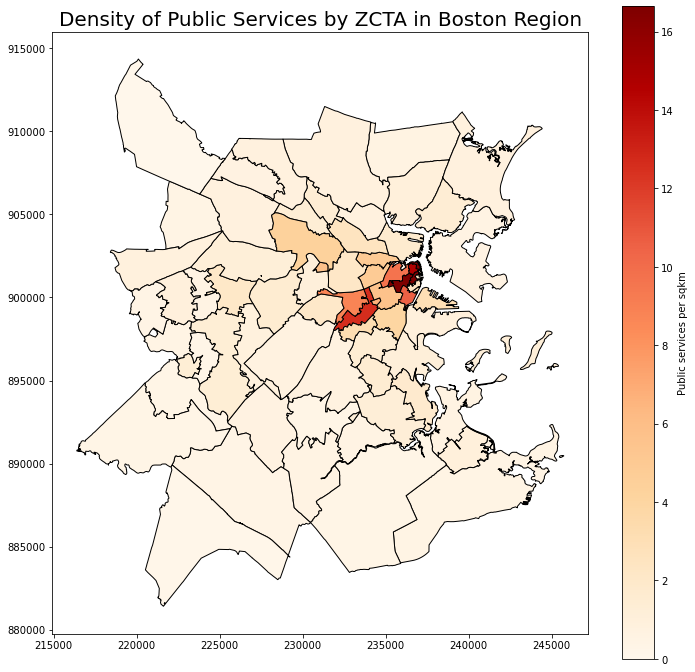

In [108]:
# Map the density of public services in each ZCTA.
ax = zcta_public_service.plot(column = 'public_service_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Public services per sqkm"})
plt.title('Density of Public Services by ZCTA in Boston Region', fontsize = 20)
plt.show()

ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
grocery.plot(ax=ax, markersize=15, color='yellow', label='Groceries')
healthcare.plot(ax=ax, markersize=15, color='aquamarine', label='Healthcare')
comm_health.plot(ax=ax, markersize=15, color='coral', label='Community Health Centers')
hospitals.plot(ax=ax, markersize=20, color='orangered', label='Hospitals')
public_service.plot(ax=ax, markersize=10, color='dodgerblue', label='Public Services')
plt.title('Necessary Amenities within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

### Necessities/Amenities per ZCTA

In [109]:
# Use calc_density to calculate density of necessities per ZCTA.
necs_gdfs = [zcta_food, zcta_health, zcta_public_service]
on_cols = ['index', 'STATEFP00', 'ZCTA5CE00', 'GEOID00', 'CLASSFP00', 'MTFCC00', 'FUNCSTAT00', 'ALAND00', 'AWATER00', 'INTPTLAT00', 'INTPTLON00', 'PARTFLG00', 'geometry']
necs_cols = food_cols + health_cols + public_service_cols
zcta_necs = calc_density(rt_zcta, necs_gdfs, on_cols, 'left', necs_cols, 'necs_count', 'necs_density')
# View five most necessity-dense ZCTAs.
zcta_necs.sort_values(by='food_density', ascending=False).head()

,index,STATEFP00,ZCTA5CE00,GEOID00,CLASSFP00,MTFCC00,FUNCSTAT00,ALAND00,AWATER00,INTPTLAT00,...,health_count,health_density,fire_count,police_count,usps_count,library_count,public_service_count,public_service_density,necs_count,necs_density
62,437,25,02113,2502113,B5,G6350,S,272995,0,+42.3651696,...,4.0,14.653358,1.0,0.0,1.0,2.0,4.0,14.653358,55.0,201.483672
48,308,25,02199,2502199,B5,G6350,S,149678,0,+42.3474648,...,1.0,6.681462,0.0,0.0,1.0,0.0,1.0,6.681462,24.0,160.355085
68,495,25,02222,2502222,B5,G6350,S,77896,0,+42.3664695,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,9.0,115.575988
54,377,25,02110,2502110,B5,G6350,S,428520,0,+42.3573712,...,0.0,0.000000,1.0,0.0,0.0,0.0,1.0,2.378828,43.0,102.289590
36,253,25,02109,2502109,B5,G6350,S,427819,0,+42.3626531,...,2.0,4.746876,1.0,0.0,1.0,5.0,7.0,16.614066,45.0,106.804707


In [110]:
# View stats for necs_density
zcta_necs.necs_density.describe()

count     69.000000
mean      23.915001
std       40.801776
min        0.436895
25%        2.607771
50%        5.733794
75%       23.715487
max      201.483672
Name: necs_density, dtype: float64

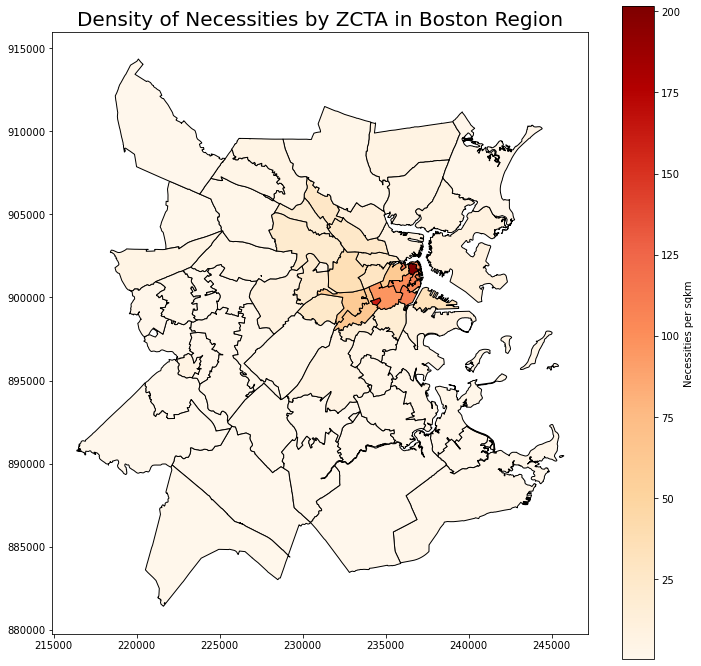

In [111]:
# Map the density of necessities in each ZCTA.
ax = zcta_necs.plot(column = 'necs_density',
                      legend = True,
                      edgecolor = 'black',
                      cmap = 'OrRd',
                      figsize = (12, 12),
                      legend_kwds={'label': "Necessities per sqkm"})
plt.title('Density of Necessities by ZCTA in Boston Region', fontsize = 20)
plt.show()

## Rent Affordability

## Bike Facilities

## Leisure